In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import trim_mean
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import math
import seaborn as sns

In [118]:
iris = pd.read_csv("IRIS.csv")

### Exploratory Data Analysis

In [119]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [120]:
iris.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [121]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [122]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [123]:
# Numerical summary only for numerical values
iris_numerical = iris[iris.select_dtypes(include=["float", "int"]).columns].copy()

# Exploratory data analysis
iris_numerical_summary = pd.DataFrame()

def trim_mean_std(series: pd.Series, percentage):
    sorted_data = np.sort(series.values)
    trim = int(percentage * len(sorted_data))
    trimmed_data = sorted_data[trim:-trim]
    return np.std(trimmed_data)

def mad(series: pd.Series):
    median = series.median()
    deviations = abs(series - median)
    return deviations.median()


index_list = [
    "Mean",
    "Median", 
    "Trimmed Mean (5%)",
    "Trimmed Mean (10%)",
    "Std",
    "MAD", # Median Absolute Deviation
    "Trimmed Mean Std (5%)",
    "Trimmed Mean Std (10%)",
    ]

iris_numerical_summary["name"] = index_list
# Explore Data
for column in iris_numerical.columns:
        iris_numerical_summary[column] = [
            iris_numerical[column].mean(),
            iris_numerical[column].median(),
            trim_mean(iris[column], 0.05),
            trim_mean(iris[column], 0.10),
            iris_numerical[column].std(),
            mad(iris[column]),
            trim_mean_std(iris_numerical[column], 0.05),
            trim_mean_std(iris_numerical[column], 0.10),
            
            ]

iris_numerical_summary = iris_numerical_summary.set_index("name")

iris_numerical_summary

,sepal_length,sepal_width,petal_length,petal_width
name,,,,
Mean,5.843333,3.054000,3.758667,1.198667
Median,5.800000,3.000000,4.350000,1.300000
Trimmed Mean (5%),5.820588,3.046324,3.747794,1.191176
Trimmed Mean (10%),5.808333,3.039167,3.760833,1.184167
Std,0.828066,0.433594,1.764420,0.763161
MAD,0.700000,0.250000,1.250000,0.700000
Trimmed Mean Std (5%),0.691558,0.341904,1.635496,0.706636
Trimmed Mean Std (10%),0.592394,0.270276,1.524374,0.648202


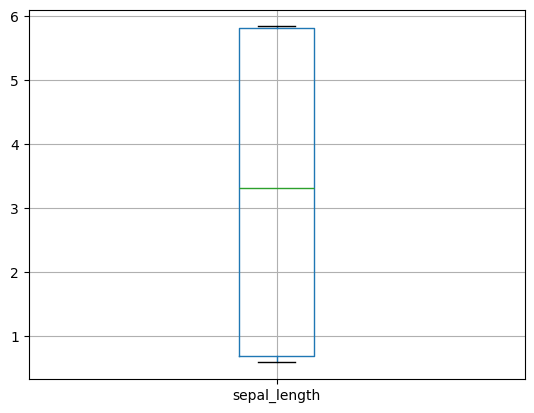

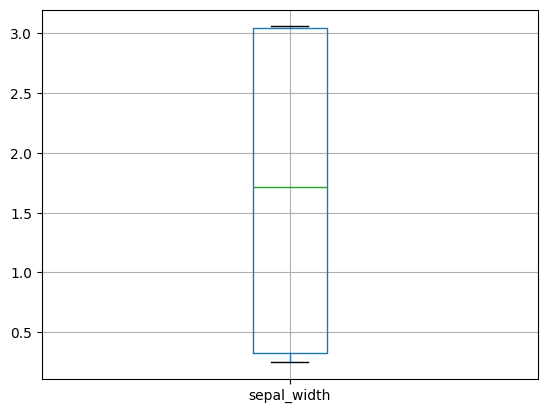

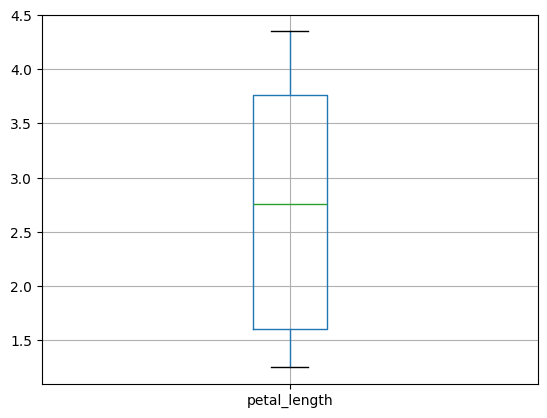

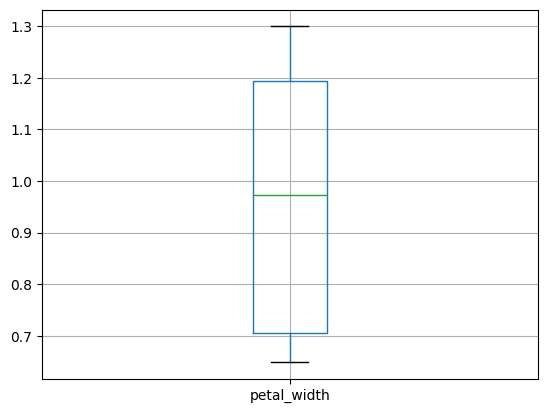

In [124]:
# Boxplots

for column in iris_numerical_summary.columns:
    iris_numerical_summary.boxplot(column=column)
    plt.show()

In [125]:
# freedman diaconis
def get_bin_width(series: pd.Series):
  q1 = series.quantile(0.25)
  q3 = series.quantile(0.75)

  iqr = q3 - q1

  return math.ceil(2 * iqr / (series.count()**(1/3)))

def get_bin_number(series: pd.Series):
  width = get_bin_width(series)
  max = series.max()
  min = series.min()

  return math.ceil((max - min) / width)

iris_bin_number = pd.DataFrame()

for column in iris_numerical.columns:
  iris_bin_number[column] = [get_bin_number(iris_numerical[column])]

iris_bin_number


# The bins are extremely small. I shall rely on boxplots and previous calculations.

,sepal_length,sepal_width,petal_length,petal_width
0,4,3,3,3


In [136]:
# Know the proportions of the feature class
class_proportions_df = pd.DataFrame({
    "count": iris["species"].value_counts(),
    "ratio": iris["species"].value_counts() / iris["species"].count()
})

class_proportions_df

,count,ratio
species,,
Iris-setosa,50,0.333333
Iris-versicolor,50,0.333333
Iris-virginica,50,0.333333


##### - The mean, median and trimmed means are close to each other for all attributes which is a good sign.
##### - The boxplots show that the 25th and 75th percentile are not that far off from the minimum and maximum, which is a good sign. No outliers detected in the boxplots.
##### - I am satisfied woth the data so, I move onto classification



### Feature Engineering

##### Petals and Sepal ratios

In [ ]:
iris_knn = pd.DataFrame()

iris_knn["sepal_ratio"] = iris["sepal_width"] / iris["sepal_length"]
iris_knn["petal_ratio"] = iris["petal_width"] / iris["petal_length"]
iris_knn["species"] = iris["species"]

label_encoder = LabelEncoder()

iris_knn["species_numeric"] = label_encoder.fit_transform(iris["species"]) 
iris_knn

,sepal_ratio,petal_ratio,species,species_numeric
0,0.686275,0.142857,Iris-setosa,0
1,0.612245,0.142857,Iris-setosa,0
2,0.680851,0.153846,Iris-setosa,0
3,0.673913,0.133333,Iris-setosa,0
4,0.720000,0.142857,Iris-setosa,0
...,...,...,...,...
145,0.447761,0.442308,Iris-virginica,2
146,0.396825,0.380000,Iris-virginica,2
147,0.461538,0.384615,Iris-virginica,2
148,0.548387,0.425926,Iris-virginica,2


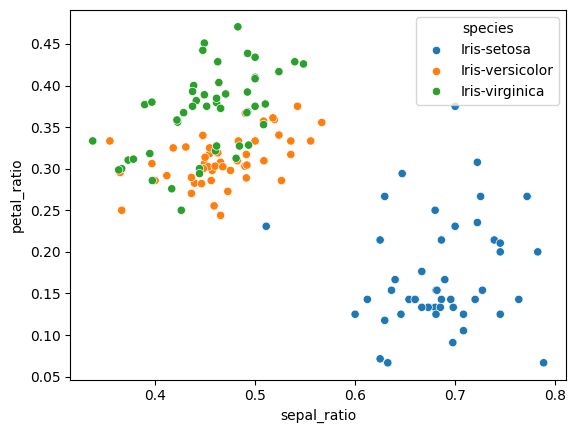

In [ ]:
sns.scatterplot(x=iris_knn["sepal_ratio"], y=iris_knn["petal_ratio"], hue=iris_knn["species"])
plt.show()

In [ ]:
# Splitting training and testing data
X = iris_knn.drop(["species", "species_numeric"], axis=1)
y = iris_knn["species_numeric"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.7, stratify=y random_state=1)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
knn.score(X_test, y_test)

0.8476190476190476

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
# Cross Validation to determine the best k value
k_values = []
max_knn = int((iris.shape[0])/(len(iris["species"].unique())))
results = []

scaler = StandardScaler()
test_X = scaler.fit_transform(X)

for i in range(1, max_knn):
    k_values.append(i)
    test_knn = KNeighborsClassifier(n_neighbors=i)
    test_score = cross_val_score(test_knn, test_X, y, cv=5)
    results.append(np.mean(test_score))

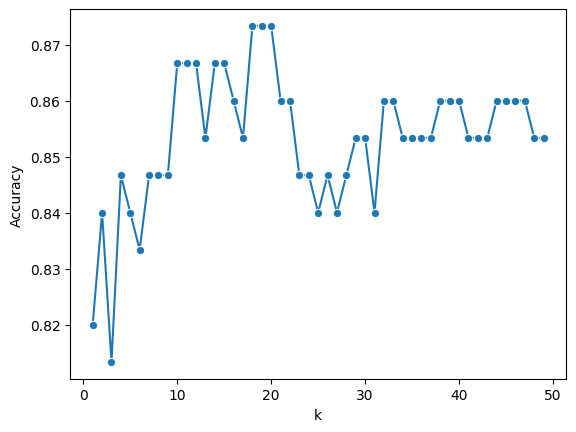

In [ ]:
# Plotting the test scores against the possible k values to determine the best k value
sns.lineplot(x = k_values, y = results, marker ="o")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()

##### I choose my k value as 18. 
##### Reasons: 
##### - It is the smallest among 18, 19 and 20 which have the highest magnitudes
##### - Even if I increase my k, the performance will not improve